In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis

In [93]:
# global variables

# Time window for the event
event_time = pd.to_datetime("2011-03-11 05:46:00")
#start_time = "2011-03-11 05:00:00"
#end_time = "2011-03-11 08:00:00"

# station ID's -> to be filled in
gs1 = 'g103'
gs2 = 'mizu'
gs3 = 'g205'
gs_id = [gs1, gs2, gs3]

# epicenter
epi_lon = 142.861 # longitude -> to be adapted
epi_lat = 38.297 # latitude -> to be adapted

# Define a sliding window size 
window_size = '10min'  # 10 minutes

# Outline

This document is based on df_filtered.csv derived from residuals_plus_bandfilter-3.ipynb\
The csv contains only satellite data of satellites in contact with groundstations during the event window.\
The csv already contains the residuals upon which this file builds up

1. Import filtered data
2. analyse timeseries with curtosis for siginificant peaks ( > 3) using a sliding window
3. norm data with sdv and mean
4. define threshold for when wave arrives at station e.g. 50
5. If threshold is passed -> wave is there, get coordinates and time
6. use horizontal distance and calculate distance to epicenter
7. v = ds/dt




In [59]:
# Load filtered data and set date as index
df = pd.read_csv('df_filtered.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

# sort by date
df_filtered = df.sort_index()

#filter between start and end time
#df = df.loc[start_time:end_time]

# analyse data columns
df.columns

Index(['year', 'month', 'day', 'hour', 'min', 'sec', 'recno', 'kindat',
       'kinst', 'ut1_unix', 'ut2_unix', 'pierce_alt', 'gps_site', 'sat_id',
       'gnss_type', 'gdlatr', 'gdlonr', 'los_tec', 'dlos_tec', 'tec', 'azm',
       'elm', 'gdlat', 'glon', 'rec_bias', 'drec_bias', 'residuals',
       'band_filtered'],
      dtype='object')

In [78]:
# build dictionary of groundstation and list of satellites in contact with gs at event_time
def get_satellites_in_contact(df, station_id, event_time):
    """
    Check which satellites were in contact with groundstationd during event time
    
    In: Dataframe, ground station id, eventtime
    Out: List of satellite ids which were in contact during event time

    """
    df_filtered = df[(df['gps_site'] == station_id) & (df.index == event_time)]
    satellites_in_contact = df_filtered['sat_id'].unique()

    return satellites_in_contact.tolist()

sat_data = {}
for i in gs_id:
    sat_data[i] = get_satellites_in_contact(df,i,event_time)

## Kurtosis (Wölbung) analysis
$\to$ from https://de.wikipedia.org/wiki/W%C3%B6lbung_(Statistik)


Die *Wölbung* (w), Kyrtosis, Kurtosis oder auch Kurtose (griechisch κύρτωσις kýrtōsis „Krümmen“, „Wölben“) ist eine Maßzahl für die Steilheit bzw. „Spitzigkeit“ einer (eingipfligen) Wahrscheinlichkeitsfunktion, statistischen Dichtefunktion oder Häufigkeitsverteilung.[1] Die Wölbung ist das standardisierte (zentrale) Moment 4. Ordnung. \
Die Wölbung kann nur nicht-negative Werte annehmen.\
- w < 3 $\to$ deutet darauf, dass die standardisierten Beobachtungen $\displaystyle z_{i}$ nahe dem Mittelwert konzentriert sind, d. h. die Verteilung ist flachgipflig
- w > 3  ist die Verteilung im Vergleich zu einer Normalverteilung spitzgipflig $\to$ indiz für peak


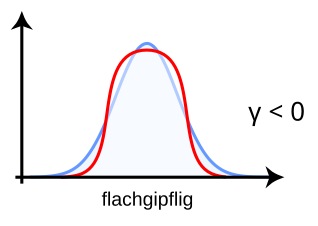 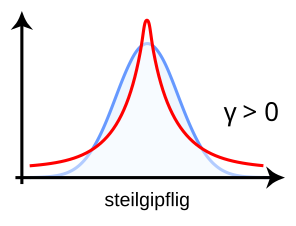


In [86]:
# Function to calculate rolling kurtosis
# calculate kurtosis with scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)

def calculate_kurtosis(group):
    return group['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)

In [87]:
def kurtosis_wrapper(x):
    return kurtosis(x, fisher=False, bias=False, nan_policy='omit')

In [94]:
# iterate through satellite per groundstaiton and calculate rolling kurtosis
results = []

"""
for station in gs_id:
    for sat_id in sat_data[i]:
        df_sat = df[(df['gps_site'] == station) & (df['sat_id'] == sat_id)]
        sat_data['kurtosis'] = df_sat['residuals'].rolling(window=window_size).apply(kurtosis_wrapper, raw=True)
        results.append(sat_data)
kurtosis_df = pd.concat(results)
"""

for station in gs_id:
    # Filter data for the specific ground station
    station_data = df[df['gps_site'] == station]

    # Group by `sat_id` (per satellite) and calculate rolling kurtosis
    station_data['kurtosis'] = station_data.groupby('sat_id').apply(calculate_kurtosis).reset_index(level=0, drop=True)
   

    # Append to results
    results.append(station_data)

# Combine all results back into one DataFrame
kurtosis_df = pd.concat(results)


/tmp/ipykernel_37007/3807684009.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_data['kurtosis'] = station_data.groupby('sat_id').apply(calculate_kurtosis).reset_index(level=0, drop=True)


ValueError: cannot reindex on an axis with duplicate labels

## Excess kurtosis
Der **Exzess** gibt die Differenz der Wölbung der betrachteten Funktion zur Wölbung der Dichtefunktion einer normalverteilten Zufallsgröße an.[1]\
Um das Ausmaß der Wölbung besser einschätzen zu können, wird sie mit der Wölbung einer Normalverteilung verglichen, für die $\beta_2 = 3$ gilt. 

Arten von Exzess:

- $\displaystyle \mathrm {Exzess} =0$: normalgipflig oder mesokurtisch. Die Normalverteilung hat die Kurtosis $\displaystyle \beta _{2}=3$ und entsprechend den Exzess .
- $\displaystyle \mathrm {Exzess} >0$: steilgipflig, supergaußförmig oder leptokurtisch. Es handelt sich hierbei um im Vergleich zur Normalverteilung spitzere Verteilungen, d. h. Verteilungen mit starken Peaks.
- $\displaystyle \mathrm {Exzess} <0$: flachgipflig, subgaußförmig oder platykurtisch. Man spricht von einer im Vergleich zur Normalverteilung abgeflachten Verteilung.

# Plotting of residuals per satellite per groundstation

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


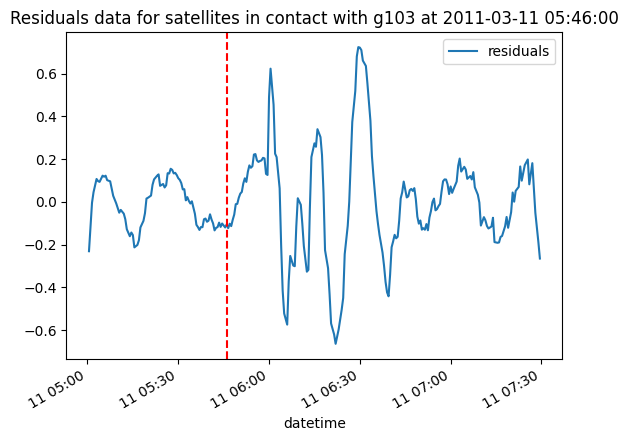

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


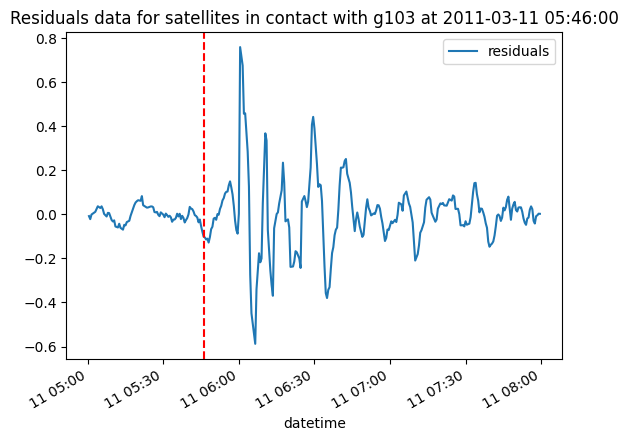

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


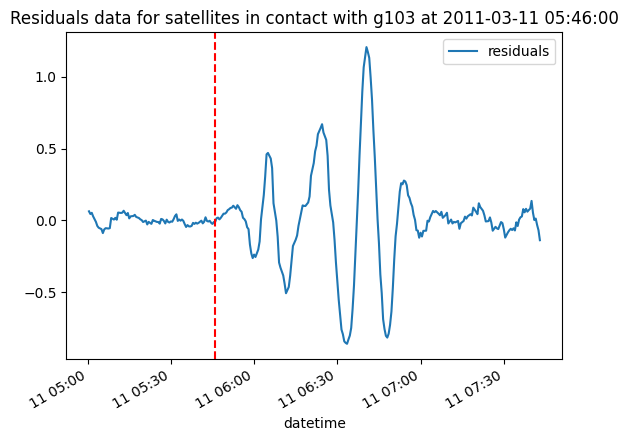

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


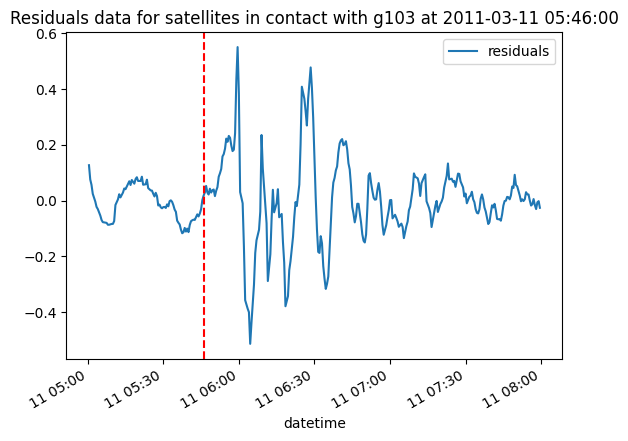

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


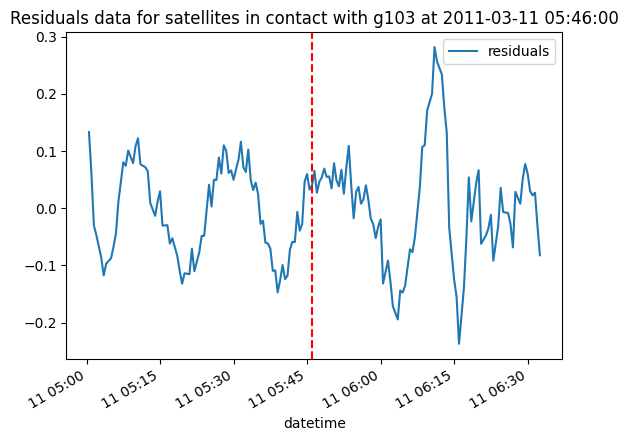

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


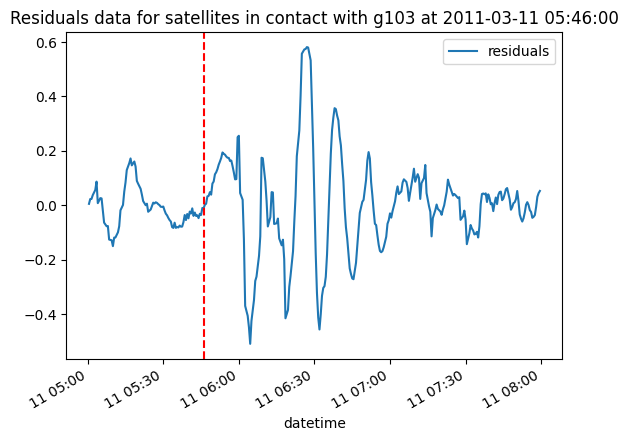

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


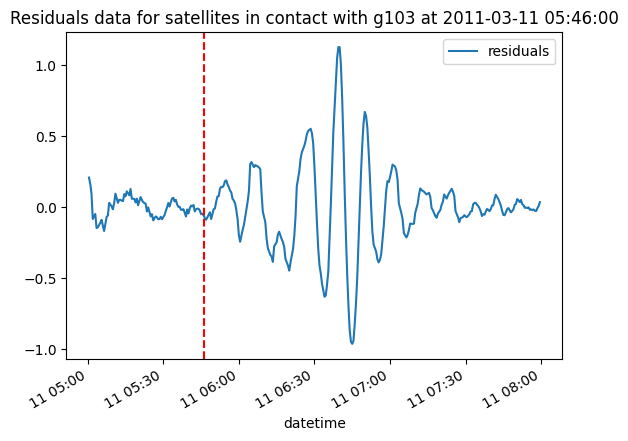

5
datetime
2011-03-11 05:00:30    5
2011-03-11 05:01:00    5
2011-03-11 05:01:30    5
2011-03-11 05:02:00    5
2011-03-11 05:03:00    5
                      ..
2011-03-11 05:57:00    5
2011-03-11 05:57:30    5
2011-03-11 05:58:00    5
2011-03-11 05:59:00    5
2011-03-11 05:59:30    5
Name: sat_id, Length: 311, dtype: int64


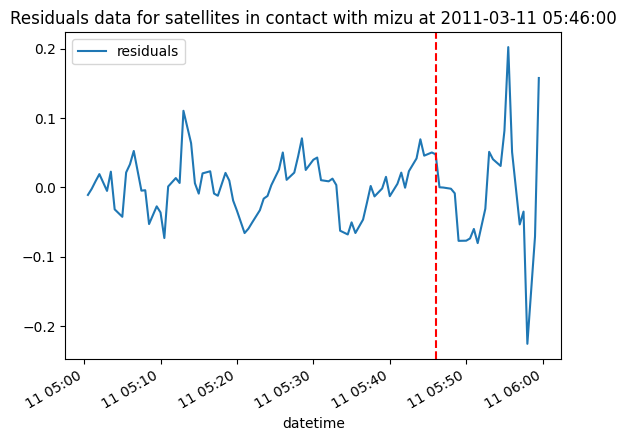

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


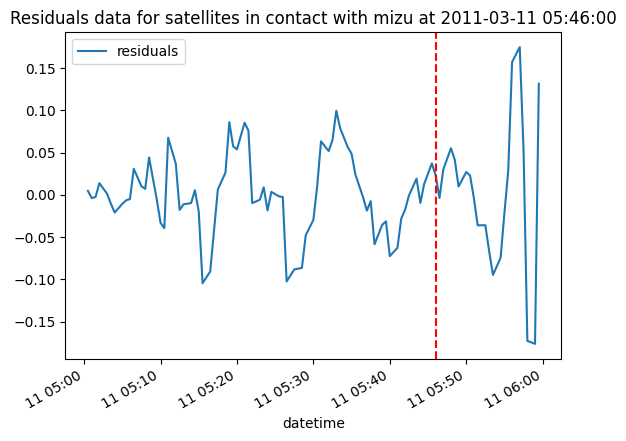

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


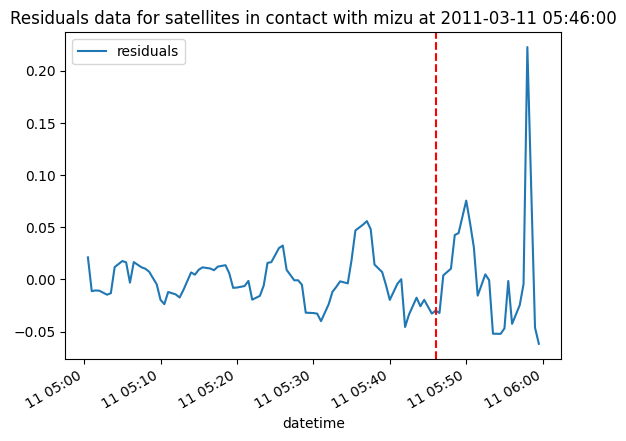

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


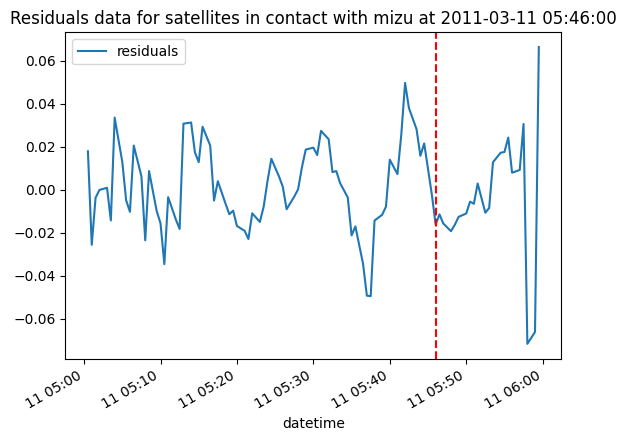

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


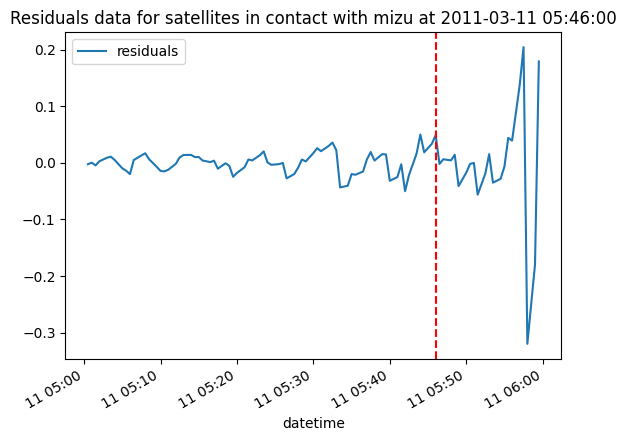

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


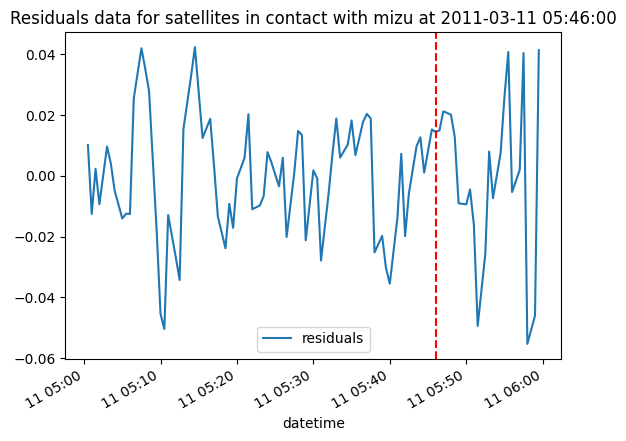

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


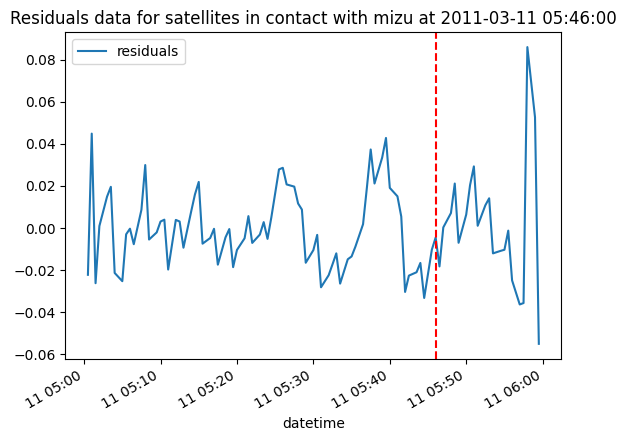

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


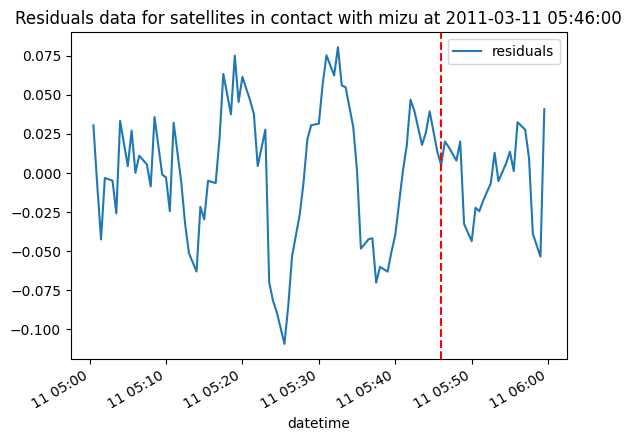

5
datetime
2011-03-11 05:00:30    5
2011-03-11 05:01:00    5
2011-03-11 05:01:30    5
2011-03-11 05:02:00    5
2011-03-11 05:03:00    5
                      ..
2011-03-11 05:57:00    5
2011-03-11 05:57:30    5
2011-03-11 05:58:00    5
2011-03-11 05:59:00    5
2011-03-11 05:59:30    5
Name: sat_id, Length: 311, dtype: int64


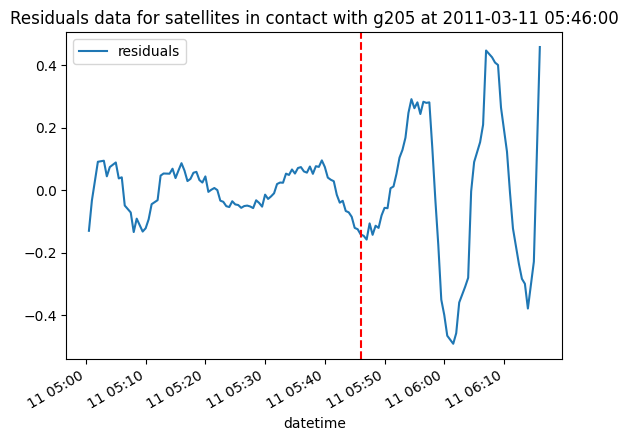

26
datetime
2011-03-11 05:00:30    26
2011-03-11 05:01:00    26
2011-03-11 05:01:30    26
2011-03-11 05:02:00    26
2011-03-11 05:03:00    26
                       ..
2011-03-11 05:57:00    26
2011-03-11 05:57:30    26
2011-03-11 05:58:00    26
2011-03-11 05:59:00    26
2011-03-11 05:59:30    26
Name: sat_id, Length: 494, dtype: int64


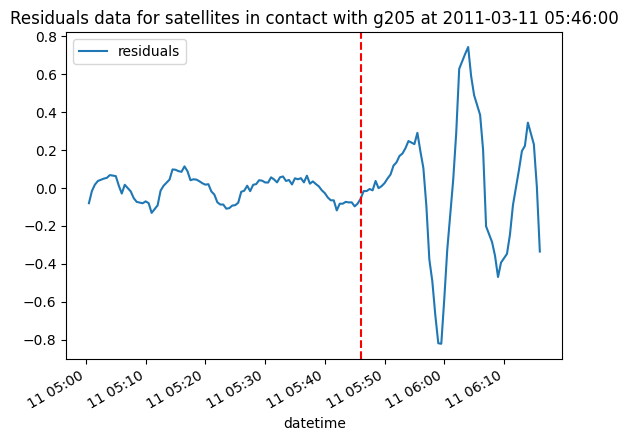

15
datetime
2011-03-11 05:00:30    15
2011-03-11 05:01:00    15
2011-03-11 05:01:30    15
2011-03-11 05:02:00    15
2011-03-11 05:03:00    15
                       ..
2011-03-11 05:57:00    15
2011-03-11 05:57:30    15
2011-03-11 05:58:00    15
2011-03-11 05:59:00    15
2011-03-11 05:59:30    15
Name: sat_id, Length: 553, dtype: int64


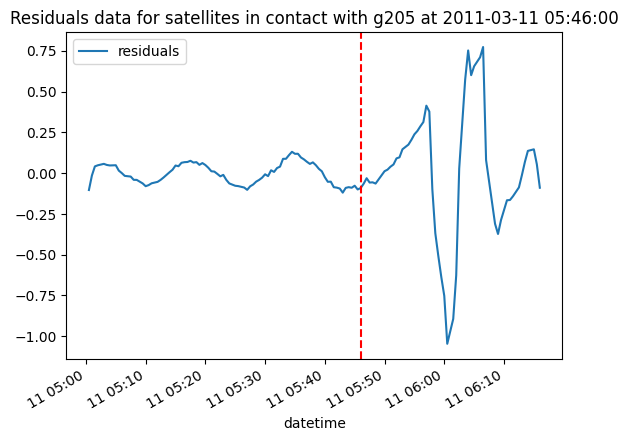

21
datetime
2011-03-11 05:00:30    21
2011-03-11 05:01:00    21
2011-03-11 05:01:30    21
2011-03-11 05:02:00    21
2011-03-11 05:03:00    21
                       ..
2011-03-11 05:57:00    21
2011-03-11 05:57:30    21
2011-03-11 05:58:00    21
2011-03-11 05:59:00    21
2011-03-11 05:59:30    21
Name: sat_id, Length: 520, dtype: int64


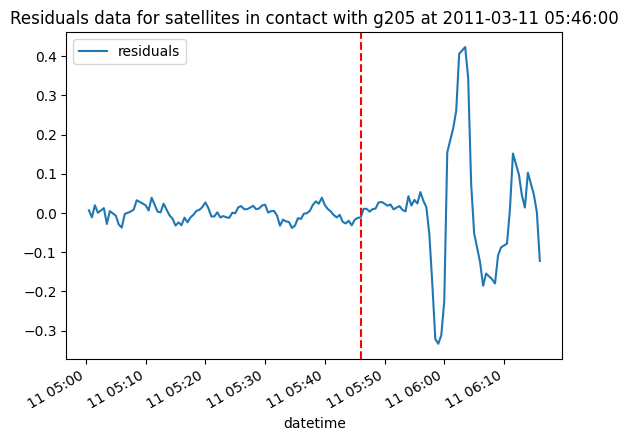

27
datetime
2011-03-11 05:00:30    27
2011-03-11 05:01:00    27
2011-03-11 05:01:30    27
2011-03-11 05:02:00    27
2011-03-11 05:03:00    27
                       ..
2011-03-11 05:57:00    27
2011-03-11 05:57:30    27
2011-03-11 05:58:00    27
2011-03-11 05:59:00    27
2011-03-11 05:59:30    27
Name: sat_id, Length: 553, dtype: int64


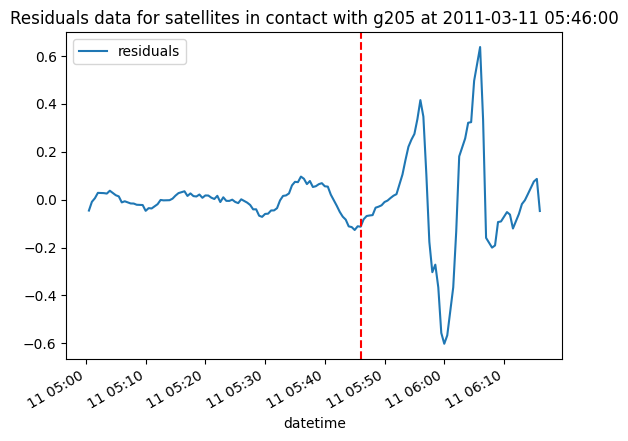

28
datetime
2011-03-11 05:00:30    28
2011-03-11 05:01:00    28
2011-03-11 05:01:30    28
2011-03-11 05:02:00    28
2011-03-11 05:03:00    28
                       ..
2011-03-11 05:57:00    28
2011-03-11 05:57:30    28
2011-03-11 05:58:00    28
2011-03-11 05:59:00    28
2011-03-11 05:59:30    28
Name: sat_id, Length: 393, dtype: int64


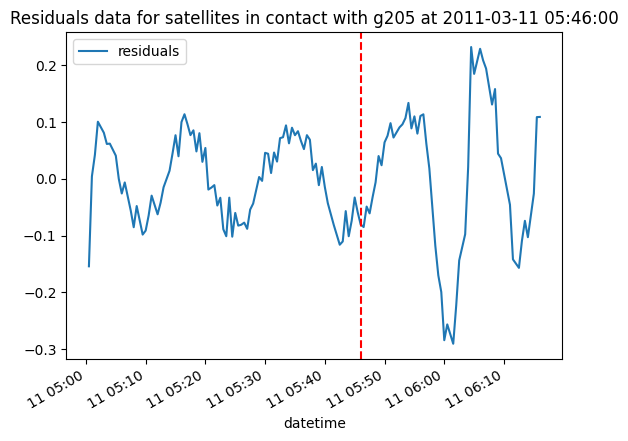

9
datetime
2011-03-11 05:00:30    9
2011-03-11 05:01:00    9
2011-03-11 05:01:30    9
2011-03-11 05:02:00    9
2011-03-11 05:03:00    9
                      ..
2011-03-11 05:57:00    9
2011-03-11 05:57:30    9
2011-03-11 05:58:00    9
2011-03-11 05:59:00    9
2011-03-11 05:59:30    9
Name: sat_id, Length: 553, dtype: int64


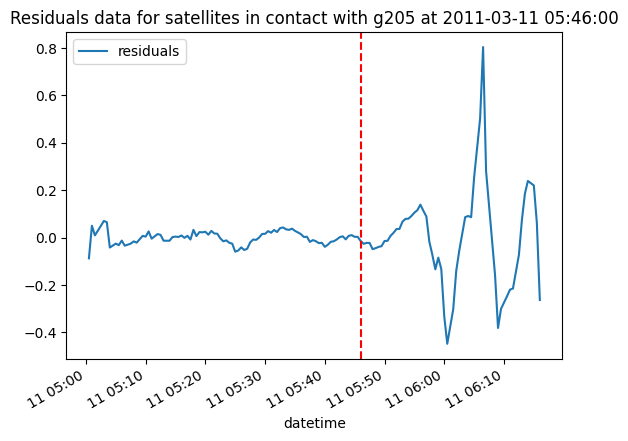

18
datetime
2011-03-11 05:00:30    18
2011-03-11 05:01:00    18
2011-03-11 05:01:30    18
2011-03-11 05:02:00    18
2011-03-11 05:03:00    18
                       ..
2011-03-11 05:57:00    18
2011-03-11 05:57:30    18
2011-03-11 05:58:00    18
2011-03-11 05:59:00    18
2011-03-11 05:59:30    18
Name: sat_id, Length: 553, dtype: int64


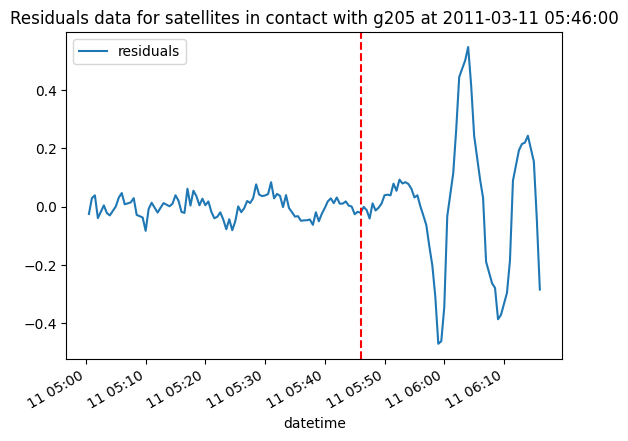

In [ ]:
# plot residuals for each satellite in contact with groundstation
def plot_tec(df, sat_id, station_id, event_time):
    #filter for satellites in df
    df_filtered = df[(df['gps_site'] == station_id) & (df['sat_id'] == sat_id)]
    df_filtered.plot(y = 'residuals', title = f'Residuals data for satellites in contact with {station_id} at {event_time}')
    # indicate event
    plt.axvline(x=event_time, color='r', linestyle='--',label="Event Marker")
    plt.show()
for i in gs_id:
    for sat_id in sat_data[i]:
        print(sat_id)
        print(df.loc[df['sat_id'] == sat_id, 'sat_id'])
        plot_tec(df, sat_id, i, event_time)
    